**Goal:**

In this notebook we will be building a hardware accelerated finite volume  simulation with JAX.

**Credits:**

The code used if based on this tutorial by Philip Mocz. We will be porting the logic to JAX.

https://github.com/pmocz/finitevolume-python/blob/master/finitevolume.py



In [ ]:
!pip install chex

In [ ]:
import jax
import chex
from jax import jit, lax
import jax.numpy as jnp


## Modelling in JAX

The `jax.numpy` module in JAX is a drop in replacement and has most of the numpy API. The key thing to remember is that JAX requires you to use pure functions: all the input data is passed through the function parameters, all the results are output through the function results. A pure function will always return the same result if invoked with the same inputs.

The code from the tutorial already used pure functions, so the only change needed to port from numpy to JAX was to change numpy call from `np` to `jnp`. This example shows how easy it existing python code can be converted into JAX.
Keep in mind that numpy is executed on the host machine and JAX functions are compiled and executed on the device (GPU/TPU). We need to be aware about where we transfer data from the host (CPU) to device and vice-versa. Unintentional data transfer from device to host slowing down execution.


In [ ]:
def getConserved( rho, vx, vy, P, gamma, vol ):
	"""
    Calculate the conserved variable from the primitive
	rho      is matrix of cell densities
	vx       is matrix of cell x-velocity
	vy       is matrix of cell y-velocity
	P        is matrix of cell pressures
	gamma    is ideal gas gamma
	vol      is cell volume
	Mass     is matrix of mass in cells
	Momx     is matrix of x-momentum in cells
	Momy     is matrix of y-momentum in cells
	Energy   is matrix of energy in cells
	"""
	Mass   = rho * vol
	Momx   = rho * vx * vol
	Momy   = rho * vy * vol
	Energy = (P/(gamma-1) + 0.5*rho*(vx**2+vy**2))*vol

	return Mass, Momx, Momy, Energy

In [ ]:
def getPrimitive( Mass, Momx, Momy, Energy, gamma, vol ):
	"""
    Calculate the primitive variable from the conservative
	Mass     is matrix of mass in cells
	Momx     is matrix of x-momentum in cells
	Momy     is matrix of y-momentum in cells
	Energy   is matrix of energy in cells
	gamma    is ideal gas gamma
	vol      is cell volume
	rho      is matrix of cell densities
	vx       is matrix of cell x-velocity
	vy       is matrix of cell y-velocity
	P        is matrix of cell pressures
	"""
	rho = Mass / vol
	vx  = Momx / rho / vol
	vy  = Momy / rho / vol
	P   = (Energy/vol - 0.5*rho * (vx**2+vy**2)) * (gamma-1)

	return rho, vx, vy, P

In [ ]:
def getGradient(f, dx):
	"""
    Calculate the gradients of a field
	f        is a matrix of the field
	dx       is the cell size
	f_dx     is a matrix of derivative of f in the x-direction
	f_dy     is a matrix of derivative of f in the y-direction
	"""
  # directions for jnp.roll()
	R = -1   # right
	L = 1    # left

	f_dx = ( jnp.roll(f,R,axis=0) - jnp.roll(f,L,axis=0) ) / (2*dx)
	f_dy = ( jnp.roll(f,R,axis=1) - jnp.roll(f,L,axis=1) ) / (2*dx)

	return f_dx, f_dy


In [ ]:
def slopeLimit(f, dx, f_dx, f_dy):
	"""
    Apply slope limiter to slopes
	f        is a matrix of the field
	dx       is the cell size
	f_dx     is a matrix of derivative of f in the x-direction
	f_dy     is a matrix of derivative of f in the y-direction
	"""
	# directions for jnp.roll()
	R = -1   # right
	L = 1    # left

	f_dx = jnp.maximum(0., jnp.minimum(1., ( (f-jnp.roll(f,L,axis=0))/dx)/(f_dx + 1.0e-8*(f_dx==0)))) * f_dx
	f_dx = jnp.maximum(0., jnp.minimum(1., (-(f-jnp.roll(f,R,axis=0))/dx)/(f_dx + 1.0e-8*(f_dx==0)))) * f_dx
	f_dy = jnp.maximum(0., jnp.minimum(1., ( (f-jnp.roll(f,L,axis=1))/dx)/(f_dy + 1.0e-8*(f_dy==0)))) * f_dy
	f_dy = jnp.maximum(0., jnp.minimum(1., (-(f-jnp.roll(f,R,axis=1))/dx)/(f_dy + 1.0e-8*(f_dy==0)))) * f_dy

	return f_dx, f_dy


In [ ]:
def extrapolateInSpaceToFace(f, f_dx, f_dy, dx):
	"""
    Calculate the gradients of a field
	f        is a matrix of the field
	f_dx     is a matrix of the field x-derivatives
	f_dy     is a matrix of the field y-derivatives
	dx       is the cell size
	f_XL     is a matrix of spatial-extrapolated values on `left' face along x-axis
	f_XR     is a matrix of spatial-extrapolated values on `right' face along x-axis
	f_YL     is a matrix of spatial-extrapolated values on `left' face along y-axis
	f_YR     is a matrix of spatial-extrapolated values on `right' face along y-axis
	"""
	# directions for np.roll()
	R = -1   # right
	L = 1    # left

	f_XL = f - f_dx * dx/2
	f_XL = jnp.roll(f_XL,R,axis=0)
	f_XR = f + f_dx * dx/2

	f_YL = f - f_dy * dx/2
	f_YL = jnp.roll(f_YL,R,axis=1)
	f_YR = f + f_dy * dx/2

	return f_XL, f_XR, f_YL, f_YR


In [ ]:
def applyFluxes(F, flux_F_X, flux_F_Y, dx, dt):
	"""
    Apply fluxes to conserved variables
	F        is a matrix of the conserved variable field
	flux_F_X is a matrix of the x-dir fluxes
	flux_F_Y is a matrix of the y-dir fluxes
	dx       is the cell size
	dt       is the timestep
	"""
	# directions for np.roll()
	R = -1   # right
	L = 1    # left

	# update solution
	F += - dt * dx * flux_F_X
	F +=   dt * dx * jnp.roll(flux_F_X,L,axis=0)
	F += - dt * dx * flux_F_Y
	F +=   dt * dx * jnp.roll(flux_F_Y,L,axis=1)

	return F


In [ ]:
def getFlux(rho_L, rho_R, vx_L, vx_R, vy_L, vy_R, P_L, P_R, gamma):
	"""
    Calculate fluxed between 2 states with local Lax-Friedrichs/Rusanov rule
	rho_L        is a matrix of left-state  density
	rho_R        is a matrix of right-state density
	vx_L         is a matrix of left-state  x-velocity
	vx_R         is a matrix of right-state x-velocity
	vy_L         is a matrix of left-state  y-velocity
	vy_R         is a matrix of right-state y-velocity
	P_L          is a matrix of left-state  pressure
	P_R          is a matrix of right-state pressure
	gamma        is the ideal gas gamma
	flux_Mass    is the matrix of mass fluxes
	flux_Momx    is the matrix of x-momentum fluxes
	flux_Momy    is the matrix of y-momentum fluxes
	flux_Energy  is the matrix of energy fluxes
	"""

	# left and right energies
	en_L = P_L/(gamma-1)+0.5*rho_L * (vx_L**2+vy_L**2)
	en_R = P_R/(gamma-1)+0.5*rho_R * (vx_R**2+vy_R**2)

	# compute star (averaged) states
	rho_star  = 0.5*(rho_L + rho_R)
	momx_star = 0.5*(rho_L * vx_L + rho_R * vx_R)
	momy_star = 0.5*(rho_L * vy_L + rho_R * vy_R)
	en_star   = 0.5*(en_L + en_R)

	P_star = (gamma-1)*(en_star-0.5*(momx_star**2+momy_star**2)/rho_star)

	# compute fluxes (local Lax-Friedrichs/Rusanov)
	flux_Mass   = momx_star
	flux_Momx   = momx_star**2/rho_star + P_star
	flux_Momy   = momx_star * momy_star/rho_star
	flux_Energy = (en_star+P_star) * momx_star/rho_star

	# find wavespeeds
	C_L = jnp.sqrt(gamma*P_L/rho_L) + jnp.abs(vx_L)
	C_R = jnp.sqrt(gamma*P_R/rho_R) + jnp.abs(vx_R)
	C = jnp.maximum( C_L, C_R )

	# add stabilizing diffusive term
	flux_Mass   -= C * 0.5 * (rho_L - rho_R)
	flux_Momx   -= C * 0.5 * (rho_L * vx_L - rho_R * vx_R)
	flux_Momy   -= C * 0.5 * (rho_L * vy_L - rho_R * vy_R)
	flux_Energy -= C * 0.5 * ( en_L - en_R )

	return flux_Mass, flux_Momx, flux_Momy, flux_Energy


## Simulation Loop

This is where things start to differ. JAX operates on pure functions however a simulation is an iterative stateful process.

The State Monad in functional programming can be used to our create simulation. Each iteration of the simulation can be seen to take in a state, perform computation and return a new state.

```
iteration : s -> (s, a)
```

Another advantage that we get from this pattern is that we can save the state of simulation at a particular iteration and replay from that point.

For a physics simulation such as this, there are a lot of variables in the state. To encapsulate them we create immutable dataclasses. Typically for working with classes in JAX we need to define how the class has to be flattened and unflattened. chex is a library in the JAX ecosystem with a convenient utilities.

In [ ]:
@chex.dataclass
class State:
  Mass: jax.Array
  Momx: jax.Array
  Momy: jax.Array
  Energy: jax.Array

@chex.dataclass
class Environment:
  courant_fac: jnp.float32
  dx: jnp.float32
  gamma: jnp.float32
  vol: jnp.float32

In [ ]:
@jit
def iteration(environment: Environment, state: State) -> State:
  dx = environment.dx
  gamma = environment.gamma
  vol = environment.vol

  Mass = state.Mass
  Momx = state.Momx
  Momy = state.Momy
  Energy = state.Energy

  rho, vx, vy, P = getPrimitive( Mass, Momx, Momy, Energy, gamma, vol )
  dt = environment.courant_fac * jnp.min( dx / (jnp.sqrt( gamma*P/rho ) + jnp.sqrt(vx**2+vy**2)) )

  # calculate gradients
  rho_dx, rho_dy = getGradient(rho, dx)
  vx_dx,  vx_dy  = getGradient(vx,  dx)
  vy_dx,  vy_dy  = getGradient(vy,  dx)
  P_dx,   P_dy   = getGradient(P,   dx)

  # extrapolate half-step in time
  rho_prime = rho - 0.5*dt * ( vx * rho_dx + rho * vx_dx + vy * rho_dy + rho * vy_dy)
  vx_prime  = vx  - 0.5*dt * ( vx * vx_dx + vy * vx_dy + (1/rho) * P_dx )
  vy_prime  = vy  - 0.5*dt * ( vx * vy_dx + vy * vy_dy + (1/rho) * P_dy )
  P_prime   = P   - 0.5*dt * ( gamma*P * (vx_dx + vy_dy)  + vx * P_dx + vy * P_dy )

  # extrapolate in space to face centers
  rho_XL, rho_XR, rho_YL, rho_YR = extrapolateInSpaceToFace(rho_prime, rho_dx, rho_dy, dx)
  vx_XL,  vx_XR,  vx_YL,  vx_YR  = extrapolateInSpaceToFace(vx_prime,  vx_dx,  vx_dy,  dx)
  vy_XL,  vy_XR,  vy_YL,  vy_YR  = extrapolateInSpaceToFace(vy_prime,  vy_dx,  vy_dy,  dx)
  P_XL,   P_XR,   P_YL,   P_YR   = extrapolateInSpaceToFace(P_prime,   P_dx,   P_dy,   dx)

  # compute fluxes (local Lax-Friedrichs/Rusanov)
  flux_Mass_X, flux_Momx_X, flux_Momy_X, flux_Energy_X = getFlux(rho_XL, rho_XR, vx_XL, vx_XR, vy_XL, vy_XR, P_XL, P_XR, gamma)
  flux_Mass_Y, flux_Momy_Y, flux_Momx_Y, flux_Energy_Y = getFlux(rho_YL, rho_YR, vy_YL, vy_YR, vx_YL, vx_YR, P_YL, P_YR, gamma)

  # update solution
  Mass   = applyFluxes(Mass, flux_Mass_X, flux_Mass_Y, dx, dt)
  Momx   = applyFluxes(Momx, flux_Momx_X, flux_Momx_Y, dx, dt)
  Momy   = applyFluxes(Momy, flux_Momy_X, flux_Momy_Y, dx, dt)
  Energy = applyFluxes(Energy, flux_Energy_X, flux_Energy_Y, dx, dt)

  # update time
  # t += dt

  return state.replace(
      Mass = Mass,
      Momx = Momx,
      Momy = Momy,
      Energy = Energy
  )

In [ ]:
@jit
def multi_step(environment: Environment, state: State, count: int):
  return lax.fori_loop(0, count, lambda i, s: iteration(environment, s), state)

In [ ]:
from jax import tree_util
import numpy as np

def run_simulation(
    environment: Environment,
    state: State,
    count: int,
    nr_snapshots: int = 10
):
  nr_iter_per_snapshot = count // nr_snapshots

  results = [state]
  for i in range(nr_snapshots):
    state = multi_step(environment, state, nr_iter_per_snapshot)
    results.append(state)

  # Get data from device
  results = jax.device_get(results)

  return tree_util.tree_map(lambda *xs: np.stack([np.array(x) for x in xs]), *results)


## Initial Conditions

### Environment

In [ ]:
# Simulation parameters
N                      = 128 # resolution
boxsize                = 1.
gamma                  = 5/3 # ideal gas gamma
courant_fac            = 0.4
t                      = 0
tEnd                   = 2
tOut                   = 0.02 # draw frequency

# Mesh
dx = boxsize / N
vol = dx**2

environment = Environment(
  courant_fac=courant_fac,
  dx=dx,
  gamma=gamma,
  vol=vol
)

In [ ]:
xlin = jnp.linspace(0.5*dx, boxsize-0.5*dx, N)
Y, X = jnp.meshgrid( xlin, xlin )

# Generate Initial Conditions - opposite moving streams with perturbation
w0 = 0.1
sigma = 0.05/jnp.sqrt(2.)
rho = 1. + (jnp.abs(Y-0.5) < 0.25)
vx = -0.5 + (jnp.abs(Y-0.5)<0.25)
vy = w0*jnp.sin(4*jnp.pi*X) * ( jnp.exp(-(Y-0.25)**2/(2 * sigma**2)) + jnp.exp(-(Y-0.75)**2/(2*sigma**2)) )
P = 2.5 * jnp.ones(X.shape)


# Get conserved variables
Mass, Momx, Momy, Energy = getConserved( rho, vx, vy, P, gamma, vol )

initial_state = State(
    Mass=Mass,
    Momx=Momx,
    Momy=Momy,
    Energy=Energy
)


## Running the simulation

In [ ]:
nr_iterations = 1000
nr_snapshots = 100
results = run_simulation(environment, initial_state, nr_iterations, nr_snapshots)

In [ ]:
%timeit -n 1 run_simulation(environment, initial_state, nr_iterations, nr_snapshots)

335 ms ± 66 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Visualization

In [ ]:
import matplotlib.pyplot as plt
import skimage.filters
import proglog
from moviepy.editor import ImageSequenceClip

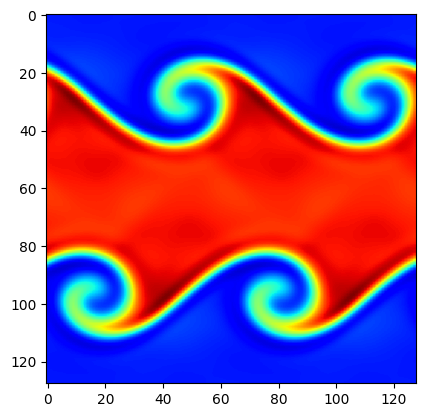

In [ ]:
plt.imshow(results.Mass[-1].T / vol, cmap='jet')
plt.clim(0.8, 2.2)

In [ ]:
import matplotlib.cm
import matplotlib.colors
from PIL import Image

def make_images(data, cmap='jet', vmax=None, vmin=None):
  images = []
  for frame in data:
    if vmax is None:
      this_vmax = np.max(abs(frame))
    else:
      this_vmax = vmax
    if vmin is None:
      this_vmin = np.min(abs(frame))
    else:
      this_vmin = vmin
    norm = matplotlib.colors.Normalize(vmin=-this_vmin, vmax=this_vmax)
    mappable = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
    rgba = mappable.to_rgba(frame, bytes=True)
    image = Image.fromarray(rgba, mode='RGBA')
    images.append(image)
  return images

def save_movie(images, path, duration=100, loop=0, **kwargs):
  images[0].save(path, save_all=True, append_images=images[1:],
                 duration=duration, loop=loop, **kwargs)

images = make_images((results.Mass / vol).transpose(0, 2, 1), vmax=2.2, vmin=0.8)

In [ ]:
from functools import partial

proglog.default_bar_logger = partial(proglog.default_bar_logger, None)
ImageSequenceClip([np.array(im) for im in images], fps=25).ipython_display()


In [22]:
# Save GIF.
save_movie(images,'finite_volume_sim.gif', duration=[2000]+[200]*(len(images)-2)+[2000])
# The movie sometimes takes a second before showing up in the file system.
import time; time.sleep(1)

In [24]:
# Download animation.
try:
    from google.colab import files
except ImportError:
    pass
else:
    files.download('finite_volume_sim.gif')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Reference

1. https://github.com/pmocz/finitevolume-python/blob/master/finitevolume.py
2. https://github.com/google/jax/blob/main/cloud_tpu_colabs/Wave_Equation.ipynb
